In [1]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import pymoc
import glob
from time import sleep
import os


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
import pyvo as vo
from scipy.stats import ks_2samp

In [31]:
def find_pixels(ra_target,dec_target,radius,priors,posterior):
    
    rep_map_new = xidplus.posterior_maps.replicated_maps(priors,posterior)
    
    bval_map_new = xidplus.posterior_maps.make_Bayesian_pval_maps(priors[0],rep_map_new[0])
    pval_map_new = xidplus.posterior_maps.make_fits_image(priors[0],bval_map_new)
    
    wcs_new = wcs.WCS(pval_map_new[1].header)
    x = np.arange(0,pval_map_new[1].header['NAXIS1'],1)
    y = np.arange(0,pval_map_new[1].header['NAXIS2'],1)
    
    x,y = np.meshgrid(x,y)
    ras,decs = wcs_new.wcs_pix2world(x,y,0,ra_dec_order=True)
    
    pixels = []
    for n in range(len(ra_target)):
        dist = (ras-ra_target[n])**2 + (decs-dec_target[n])**2
        #print(len(dist))
        pixel_mask = dist<(radius**2)
        #print(np.sum(pixel_mask))
        mask = ~np.isnan(pval_map_new[1].data)
        #print(np.sum(mask))
        pixels_mask_flat = pixel_mask[mask].flatten()
        #print(np.sum(pixels_mask_flat))
        pixels.append(np.arange(0,np.sum(mask),1)[pixels_mask_flat])
    
    return(pixels)

def pval_map_sum(ra_target,dec_target,prior_new,prior_old,posterior_new,posterior_old,radius):
    
    #pixels_newx = prior_new.sx_pix
    #pixels_newy = prior_new.sy_pix
    
    #pixels_oldx = prior_old.sx_pix
    #pixels_oldy = prior_old.sy_pix
    
    #ids = priors_new.ID
    #mask = ids==source_id
    
    rep_map_new = xidplus.posterior_maps.replicated_maps(prior_new,posterior_new)
    bval_map_new = xidplus.posterior_maps.make_Bayesian_pval_maps(prior_new[0],rep_map_new[0])
    pval_map_new = xidplus.posterior_maps.make_fits_image(prior_new[0],bval_map_new)
    
    wcs_new = wcs.WCS(pval_map_new[1].header)
    x = np.arange(0,pval_map_new[1].header['NAXIS1'],1)
    y = np.arange(0,pval_map_new[1].header['NAXIS2'],1)

    x,y = np.meshgrid(x,y)
    ras,decs = wcs_new.wcs_pix2world(x,y,0,ra_dec_order=True)
    tot_pval_new = []
    for n in range(len(ra_target)):
        dist = (ras-ra_target[n])**2 + (decs-dec_target[n])**2
        mask = dist<radius**2
        print('number of pixel within radius is: {}'.format(np.sum(mask)))
        x,y = wcs_new.wcs_world2pix(ras[mask],decs[mask],0,ra_dec_order=True)
        x = x.astype(int)
        y = y.astype(int)
        tot_pval_new.append(np.sum(pval_map_new[1].data[y,x]))
    
    
    rep_map_old = xidplus.posterior_maps.replicated_maps(prior_old,posterior_old)
    bval_map_old = xidplus.posterior_maps.make_Bayesian_pval_maps(prior_old[0],rep_map_old[0])
    pval_map_old = xidplus.posterior_maps.make_fits_image(prior_old[0],bval_map_old)
    
    wcs_old = wcs.WCS(pval_map_old[1].header)
    x = np.arange(0,prior_old[0].imhdu['NAXIS1'],1)
    y = np.arange(0,prior_old[0].imhdu['NAXIS2'],1)
    x,y = np.meshgrid(x,y)
    ras,decs = wcs_old.wcs_pix2world(x,y,0,ra_dec_order=True)
    
    tot_pval_old = []
    for n in range(len(ra_target)):
        dist = (ras-ra_target[n])**2 + (decs-dec_target[n])**2
        mask = dist<radius**2
        print('number of pixel within radius is: {}'.format(np.sum(mask)))
        x,y = wcs_old.wcs_world2pix(ras[mask],decs[mask],0,ra_dec_order=True)
        x = x.astype(int)
        y = y.astype(int)
        tot_pval_old.append(np.sum(pval_map_old[1].data[y,x]))
    
    
    return(tot_pval_new,tot_pval_old)

def pval_summary(pixels,sigma_level,rep_map,prior):
    
    samples = rep_map[pixels,:]
    
    t = np.sum(((samples - prior.sim[pixels, None]) / (np.sqrt(2) * prior.snim[pixels, None])) ** 2.0, axis=0)
    ind_T = t / len(pixels) > sigma_level
    Bayes_pval_res_vals = ind_T.sum()/np.float(rep_map.shape[1])
    return(Bayes_pval_res_vals)

def get_xidplus_posterior(helpids,order,tiles,filepath=None,ras=[],decs=[]):
    # function to find the healpix for the given sources of the given order. You can provid this function a
    # list of help ids and it will return the healpix tile they are in. Alternatively you can provide a list
    # of ras and decs and it will do the same only faster. Finally if you give it the directory that the xidplus
    # posteriors are stored in then it will return you the path the posterior so it can be loaded in.
    
    # you need to provide this function a list of help ids, the order of the tiles desired and a list of tiles 
    # that you have posteriors for
    
    # if you haven't provided ras or decs it converts the help ids into ras and decs
    if (len(ras)==0) & (len(decs)==0):
        ras = []
        decs = []
        
        for helpid in helpids:
            ra,dec = utils.help_id_to_ra_dec(helpid)
            ras.append(ra)
            decs.append(dec)
        ras = np.array(ras)
        decs = np.array(decs)
        
    # finds the healpix tile of the given order that the coordinate is in
    hpxids = xidplus.moc_routines.get_HEALPix_pixels(order,ras,decs,unique=False)
    
    # tells you how many of the sources you gave it have matching XID+ posteriors from
    # the tile lits you gave
    in_tiles = np.array([healid in tiles for healid in hpxids])
    print('of the {} sources given, {} are within the tile list you have'.format(len(ras),np.sum(in_tiles)))
    
    # if a filepath was provided then here it gives you the filepath to each posterior and returns the 
    #hpxids and the filenames
    if filepath!=None:
        files = []
        for hpxid in hpxids:
            file = filepath + 'Tile_{}_{}.pkl'.format(hpxid,order)
            files.append(file)
        return(hpxids,files)
    
    # returns just the healpix ids if no filepath was given
    return(hpxids)

#This cell is now outdated with the newer catalogue releases

#Read in the LOFAR data both optical and radio
lofar_rad = Table.read('data/radio/EN1_ML_RUN_fin_overlap_srl_workflow.fits')
lofar_opt = Table.read('data/optical/EN1_MASTER_opt_spitzer_merged_cedit_apcorr.fits')
lofar_opt.rename_column('ALPHA_J2000','ra')
lofar_opt.rename_column('DELTA_J2000','dec')

#merge the optical and radio catalogue to find out which optical sources need crossmatching to HELP
mask = ~np.isnan(lofar_rad['lr_index_fin'])
lofar = hstack([lofar_rad[mask],lofar_opt[lofar_rad[mask]['lr_index_fin'].astype(int)]])

In [3]:
lofar = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
mask = (~np.isnan(lofar['F_SPIRE_250'])) | (~np.isnan(lofar['F_SPIRE_350'])) | (~np.isnan(lofar['F_SPIRE_500']))
lofar = lofar[~mask]

print(len(lofar))                  

8370


In [4]:
mask = lofar['Source_Name'] == 'ILTJ160253.20+544352.1'
ras = lofar['optRA'][mask]
decs = lofar['optDec'][mask]
ids = lofar['Source_Name'][mask]

In [5]:
len(ras)

1

In [6]:
#Read in the herschel images
imfolder='../../../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'

pswfits=imfolder+'ELAIS-N1_SPIRE250_v1.0.fits'#SPIRE 250 map
pmwfits=imfolder+'ELAIS-N1_SPIRE350_v1.0.fits'#SPIRE 350 map
plwfits=imfolder+'ELAIS-N1_SPIRE500_v1.0.fits'#SPIRE 500 map

#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist['image'].header

im250=hdulist['image'].data*1.0E3 #convert to mJy
nim250=hdulist['error'].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist['image'].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist['image'].header

im350=hdulist['image'].data*1.0E3 #convert to mJy
nim350=hdulist['error'].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist['image'].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist['image'].header 
im500=hdulist['image'].data*1.0E3 #convert to mJy
nim500=hdulist['error'].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist['image'].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

In [50]:
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)  
import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,60,15)

In [56]:
prior_cat = Table.read('data/data_release/xidplus_prior_cat.fits')
mask = inMoc(prior_cat['ra'],prior_cat['dec'],moc)
prior_cat = prior_cat[mask]
prior_cat[0]

ra,dec,help_id,flag_optnir_det,f_mips_24
deg,deg,,,
float64,float64,bytes1728,float64,float64
240.19064859728925,55.009261092404664,HELP_J160045.756+550033.340,5.0,88.4591


In [36]:
mask = np.array(['ILTJ' not in name for name in prior_cat['help_id']])
prior_coords = SkyCoord(ra=prior_cat['ra'][mask],dec=prior_cat['dec'][mask])

idx,d2d,_ = c.match_to_catalog_sky(prior_coords)
help_id_near = prior_cat[idx]['help_id'].data[0].decode()
print(help_id_near)
print(d2d.value*3600)

#remove help source from teh prior cat
mask = prior_cat['help_id'] == help_id_near
prior_cat = prior_cat[~mask]

HELP_J160253.217+544353.520
[0.91354663]


In [40]:
#remove the LOFAR source
mask = prior_cat['help_id']==ids
prior_cat = prior_cat[~mask]

In [41]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'])#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=moc)
prior350.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'])
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=moc)
prior500.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'])
prior500.prior_bkg(-5.0,5)

#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel



##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires PRF as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

print('fitting '+ str(prior250.nsrc)+' sources \n')
print('using ' +  str(prior250.snpix)+', '+ str(prior350.snpix)+' and '+ str(prior500.snpix)+' pixels')


prior250.get_pointing_matrix()
prior350.get_pointing_matrix()
prior500.get_pointing_matrix()

prior250.upper_lim_map()
prior350.upper_lim_map()
prior500.upper_lim_map()

from xidplus.stan_fit import SPIRE
fit=SPIRE.all_bands(prior250,prior350,prior500,iter=1000)

fitting 23 sources 

using 313, 165 and 81 pixels
/XID+SPIRE found. Reusing


In [34]:
#get results for the run where both the LOFAR and HELP source are included
posterior_both = xidplus.posterior_stan(fit,[prior250,prior350,prior500])
priors_both = [prior250,prior350,prior500]

rep_map_both = xidplus.posterior_maps.replicated_maps(priors_both,posterior_both)
bval_map_both = xidplus.posterior_maps.make_Bayesian_pval_maps(priors_both[0],rep_map_both[0])
pval_map_both = xidplus.posterior_maps.make_fits_image(priors_both[0],bval_map_both)

import xidplus.catalogue as cat
SPIRE_cat=cat.create_SPIRE_cat(posterior_both,priors_both[0],priors_both[1],priors_both[2])
SPIRE_cat_both = Table.read(SPIRE_cat)

In [38]:
#get results for the run where only the LOFAR source is included
posterior_lofar = xidplus.posterior_stan(fit,[prior250,prior350,prior500])
priors_lofar = [prior250,prior350,prior500]

rep_map_lofar = xidplus.posterior_maps.replicated_maps(priors_lofar,posterior_lofar)
bval_map_lofar = xidplus.posterior_maps.make_Bayesian_pval_maps(priors_lofar[0],rep_map_lofar[0])
pval_map_lofar = xidplus.posterior_maps.make_fits_image(priors_lofar[0],bval_map_lofar)

import xidplus.catalogue as cat
SPIRE_cat=cat.create_SPIRE_cat(posterior_lofar,priors_lofar[0],priors_lofar[1],priors_lofar[2])
SPIRE_cat_lofar = Table.read(SPIRE_cat)

In [42]:
#get results for the run where HELP is duplicated 
posterior_help = xidplus.posterior_stan(fit,[prior250,prior350,prior500])
priors_help = [prior250,prior350,prior500]

rep_map_help = xidplus.posterior_maps.replicated_maps(priors_help,posterior_help)
bval_map_help = xidplus.posterior_maps.make_Bayesian_pval_maps(priors_help[0],rep_map_help[0])
pval_map_help = xidplus.posterior_maps.make_fits_image(priors_help[0],bval_map_help)

import xidplus.catalogue as cat
SPIRE_cat=cat.create_SPIRE_cat(posterior_help,priors_help[0],priors_help[1],priors_help[2])
SPIRE_cat_help = Table.read(SPIRE_cat)

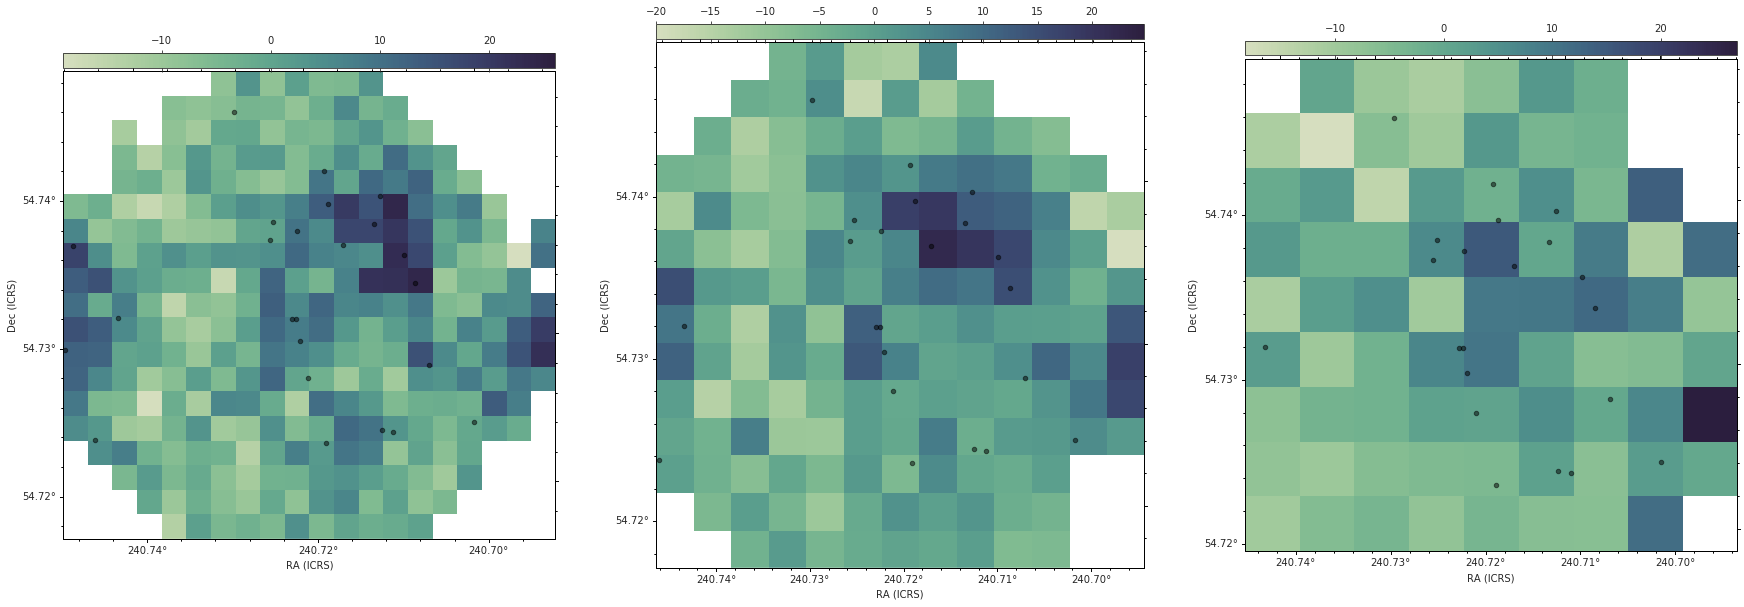

In [19]:
figs,fig=xidplus.plot_map(priors_both)

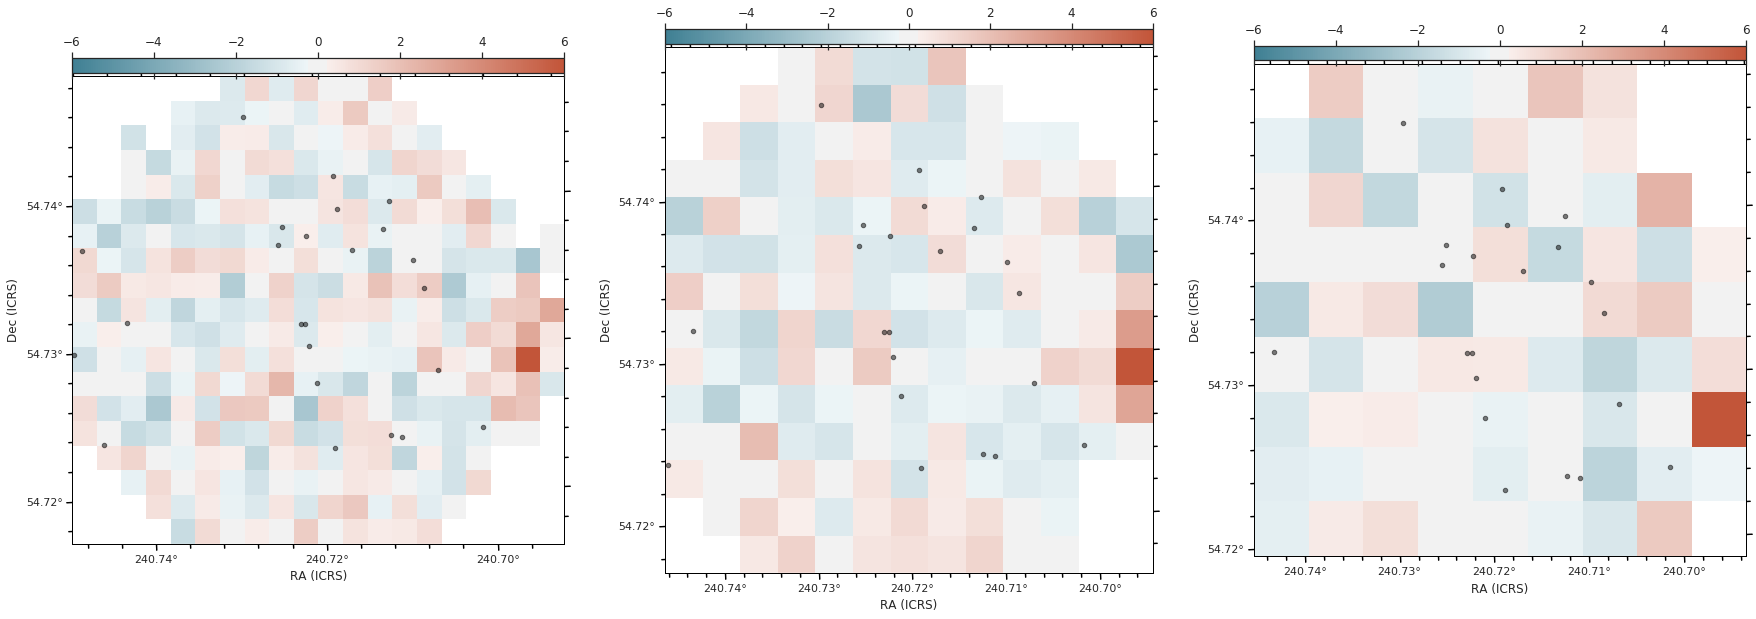

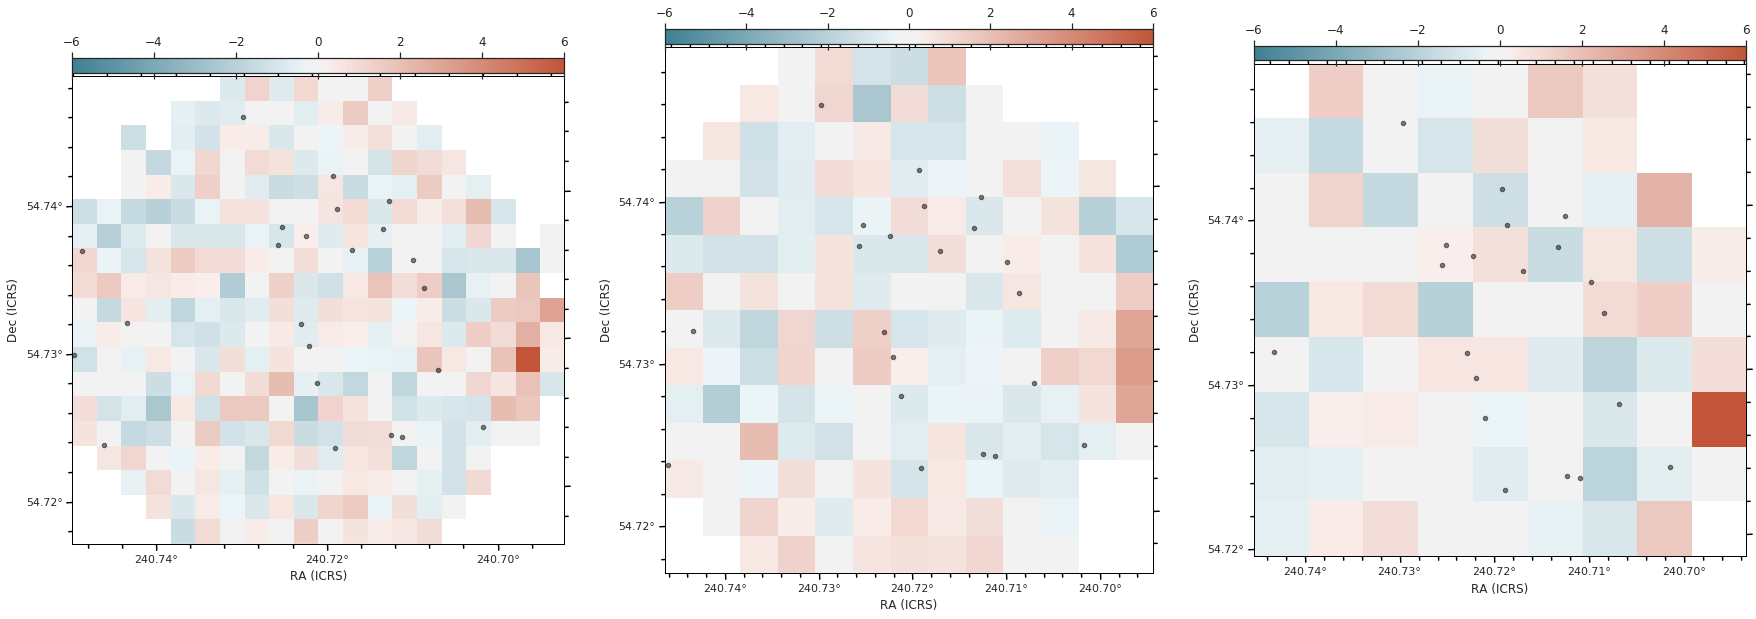

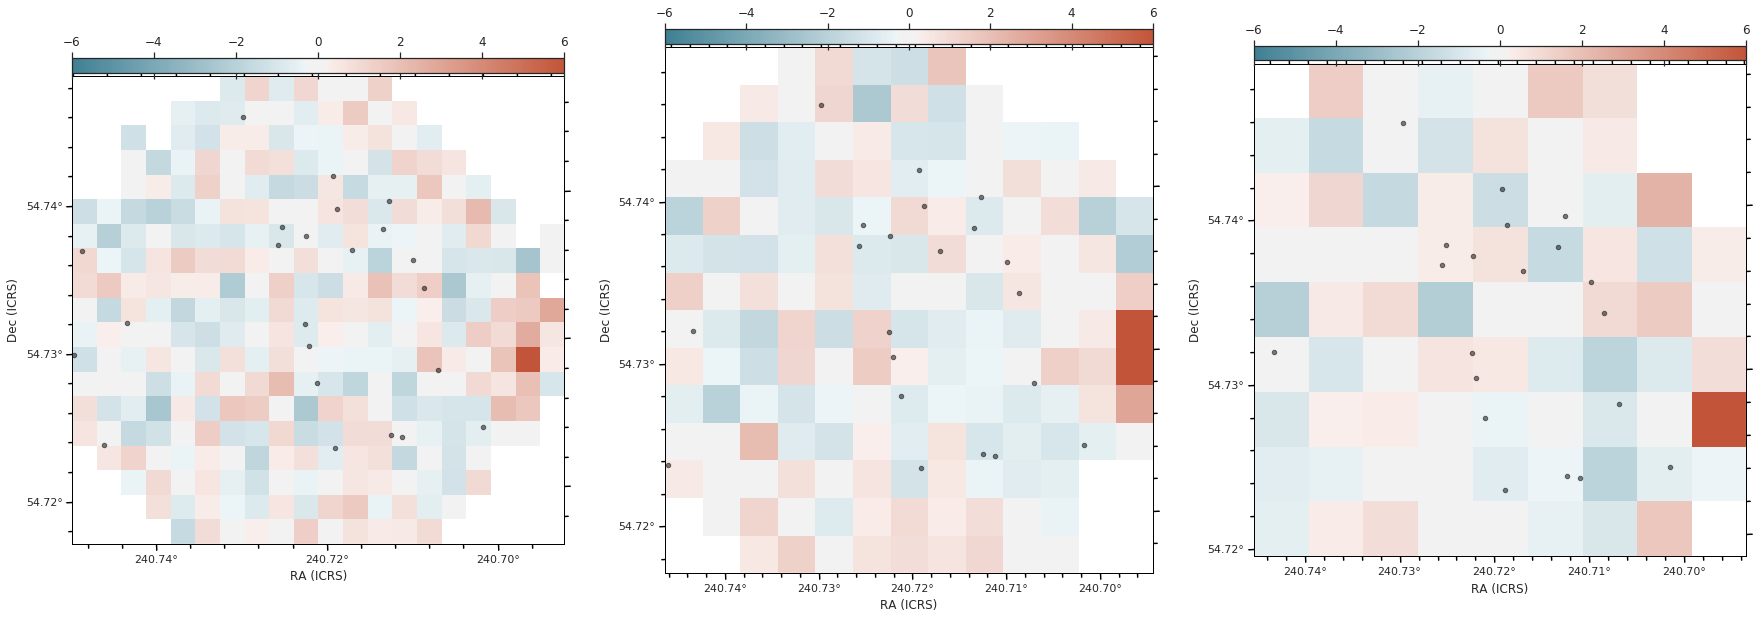

In [43]:
figs, fig=xidplus.plot_Bayes_pval_map(priors_both, posterior_both)
figs, fig=xidplus.plot_Bayes_pval_map(priors_lofar, posterior_lofar)
figs, fig=xidplus.plot_Bayes_pval_map(priors_help, posterior_help)

ILTJ160253.20+544352.1
HELP_J160253.217+544353.520


INFO:astropy:Auto-setting vmin to -2.297e+01
INFO:astropy:Auto-setting vmax to  2.859e+01


INFO: Auto-setting vmin to -2.297e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.859e+01 [aplpy.core]


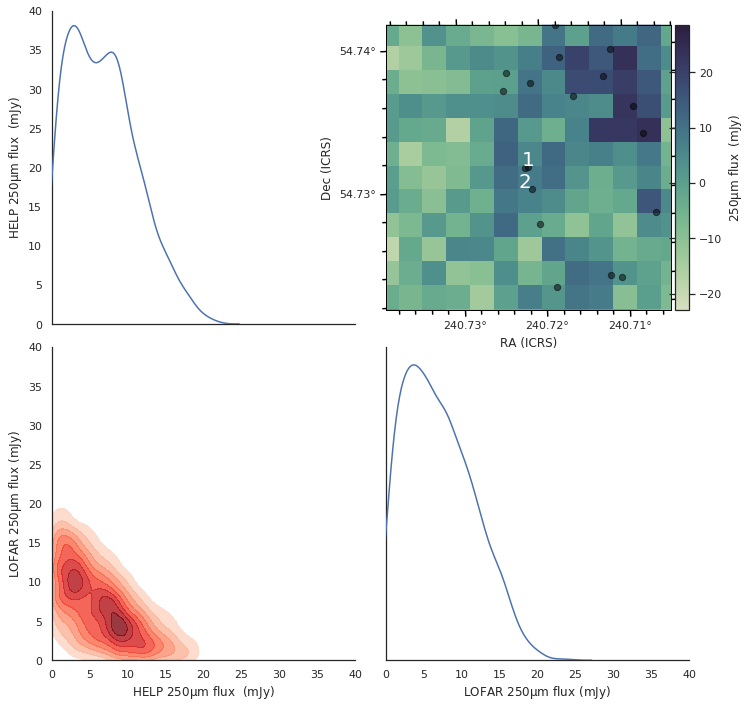

In [21]:
import aplpy
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
sns.set_style("white")
import xidplus.posterior_maps as postmaps

slofar = np.argmax(posterior_both.ID==ids)
shelp = np.argmax(posterior_both.ID==help_id_near)

print(priors_both[0].ID[slofar])
print(priors_both[0].ID[shelp])

labels=[r'HELP $250\mathrm{\mu m}$ flux  (mJy)',r'LOFAR $250\mathrm{\mu m}$ flux (mJy)']
df = pd.DataFrame(posterior_both.samples['src_f'][:,0,[shelp,slofar]],columns=labels)
g = sns.PairGrid(df,size=5)
g.map_diag(sns.kdeplot,c='Red')
g.map_lower(sns.kdeplot, cmap="Reds",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)
g.set(ylim=(0,40))
g.set(xlim=(0,40))

g.axes[0,1].spines['bottom'].set_color('white')
g.axes[0,1].spines['left'].set_color('white')
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)

real_250 = aplpy.FITSFigure(postmaps.make_fits_image(priors_both[0],priors_both[0].sim)[1],figure=g.fig,subplot=(2,2,2))
real_250.show_colorscale(cmap=cmap)

real_250.show_markers(priors_both[0].sra, priors_both[0].sdec, edgecolor='black', facecolor='black',
                marker='o', s=40, alpha=0.5)
real_250.recenter(priors_both[0].sra[shelp], priors_both[0].sdec[shelp], radius=0.01)

real_250.add_label(priors_both[0].sra[shelp], priors_both[0].sdec[shelp]+0.0005, 1, relative=False,size=20,color='white')
real_250.add_label(priors_both[0].sra[slofar], priors_both[0].sdec[slofar]-0.0010, 2, relative=False,size=20,color='white')
real_250.tick_labels.set_xformat('dd.dd')
real_250.tick_labels.set_yformat('dd.dd')


real_250.add_colorbar(axis_label_text=r'$250\mathrm{\mu m}$ flux  (mJy)')

ILTJ160253.20+544352.1
HELP_J160253.217+544353.520


INFO:astropy:Auto-setting vmin to -2.297e+01
INFO:astropy:Auto-setting vmax to  2.859e+01


INFO: Auto-setting vmin to -2.297e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.859e+01 [aplpy.core]


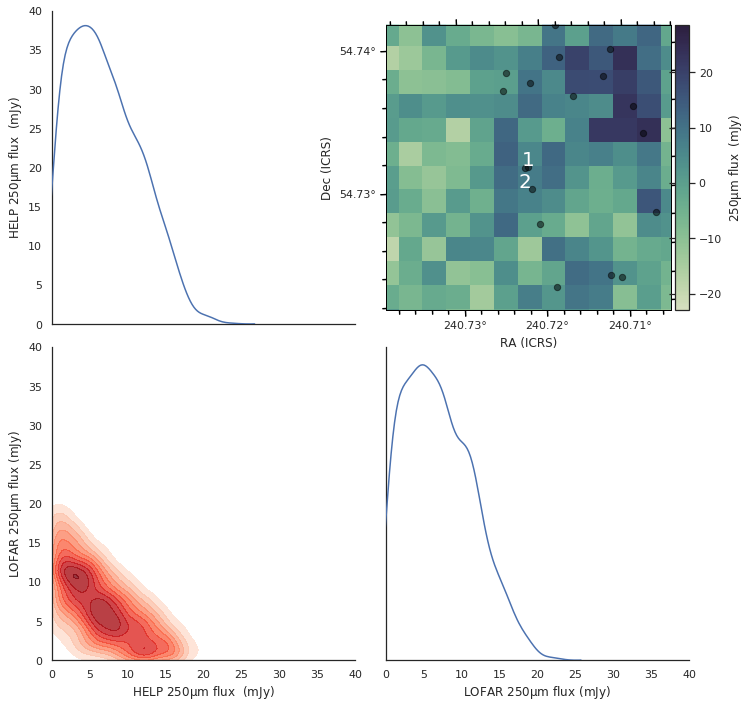

In [44]:
import aplpy
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
sns.set_style("white")
import xidplus.posterior_maps as postmaps

slofar = np.argmax(posterior_both.ID==ids)
shelp = np.argmax(posterior_both.ID==help_id_near)

print(priors_both[0].ID[slofar])
print(priors_both[0].ID[shelp])

labels=[r'HELP $250\mathrm{\mu m}$ flux  (mJy)',r'LOFAR $250\mathrm{\mu m}$ flux (mJy)']
df = pd.DataFrame(posterior_both.samples['src_f'][:,0,[shelp,slofar]],columns=labels)
g = sns.PairGrid(df,size=5)
g.map_diag(sns.kdeplot,c='Red')
g.map_lower(sns.kdeplot, cmap="Reds",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)
g.set(ylim=(0,40))
g.set(xlim=(0,40))

g.axes[0,1].spines['bottom'].set_color('white')
g.axes[0,1].spines['left'].set_color('white')
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)

real_250 = aplpy.FITSFigure(postmaps.make_fits_image(priors_both[0],priors_both[0].sim)[1],figure=g.fig,subplot=(2,2,2))
real_250.show_colorscale(cmap=cmap)

real_250.show_markers(priors_both[0].sra, priors_both[0].sdec, edgecolor='black', facecolor='black',
                marker='o', s=40, alpha=0.5)
real_250.recenter(priors_both[0].sra[shelp], priors_both[0].sdec[shelp], radius=0.01)

real_250.add_label(priors_both[0].sra[shelp], priors_both[0].sdec[shelp]+0.0005, 1, relative=False,size=20,color='white')
real_250.add_label(priors_both[0].sra[slofar], priors_both[0].sdec[slofar]-0.0010, 2, relative=False,size=20,color='white')
real_250.tick_labels.set_xformat('dd.dd')
real_250.tick_labels.set_yformat('dd.dd')


real_250.add_colorbar(axis_label_text=r'$250\mathrm{\mu m}$ flux  (mJy)')

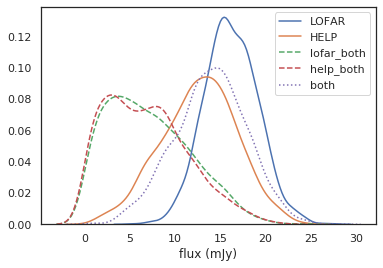

In [22]:
lofar_only = posterior_lofar.samples['src_f'][:,0,slofar]
sns.kdeplot(lofar_only,label='LOFAR')

help_only = posterior_help.samples['src_f'][:,0,shelp]
sns.kdeplot(help_only,label='HELP')

lofar_both = posterior_both.samples['src_f'][:,0,slofar]
help_both = posterior_both.samples['src_f'][:,0,shelp]
sns.kdeplot(lofar_both,label='lofar_both',linestyle='dashed')
sns.kdeplot(help_both,label='help_both',linestyle='dashed')
sns.kdeplot(help_both+lofar_both,label='both',linestyle='dotted')

plt.xlabel('flux (mJy)')
plt.show()

In [ ]:
ra_target = ras
dec_target = decs

wcs_new = wcs.WCS(pval_map_help[1].header)
x = np.arange(0,pval_map_help[1].header['NAXIS1'],1)
y = np.arange(0,pval_map_help[1].header['NAXIS2'],1)
    
x,y = np.meshgrid(x,y)
ras_pix,decs_pix = wcs_new.wcs_pix2world(x,y,0,ra_dec_order=True)
    
pixels = []
for n in range(len(ra_target)):
    dist = (ras_pix-ra_target[n])**2 + (decs_pix-dec_target[n])**2
    pixel_mask = dist<(18/3600)**2
    mask = ~np.isnan(pval_map_help[1].data)
    pixels_mask_flat = pixel_mask[mask].flatten()
    pixels.append(np.arange(0,np.sum(mask),1)[pixels_mask_flat])
    
print(pixels)

In [ ]:
ra_target = ras
dec_target = decs
radius = 18/3600
priors = priors_help
posterior = posterior_help

rep_map_new = xidplus.posterior_maps.replicated_maps(priors,posterior)
    
bval_map_new = xidplus.posterior_maps.make_Bayesian_pval_maps(priors[0],rep_map_new[0])
pval_map_new = xidplus.posterior_maps.make_fits_image(priors[0],bval_map_new)
    
wcs_new = wcs.WCS(pval_map_new[1].header)
x = np.arange(0,pval_map_new[1].header['NAXIS1'],1)
y = np.arange(0,pval_map_new[1].header['NAXIS2'],1)
    
x,y = np.meshgrid(x,y)
ras_pix,decs_pix = wcs_new.wcs_pix2world(x,y,0,ra_dec_order=True)
    
pixels = []
for n in range(len(ra_target)):
    dist = (ras_pix-ra_target[n])**2 + (decs_pix-dec_target[n])**2
    print(len(dist))
    pixel_mask = dist<(radius**2)
    print(np.sum(pixel_mask))
    mask = ~np.isnan(pval_map_new[1].data)
    print(np.sum(mask))
    pixels_mask_flat = pixel_mask[mask].flatten()
    print(np.sum(pixels_mask_flat))
    pixels.append(np.arange(0,np.sum(mask),1)[pixels_mask_flat])
    
print(pixels)

19
16
307
16
19
16
307
16
19
16
307
16


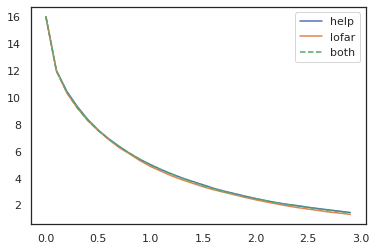

In [30]:
pixels_lofar = find_pixels(ras,decs,18/3600,priors_lofar,posterior_lofar)
pixels_help = find_pixels(ras,decs,18/3600,priors_help,posterior_help)
#pixels_help = [np.array([ 99, 118, 119, 120, 138, 139, 140, 157, 158, 159, 177, 178, 179, 196, 197])]
pixels_both = find_pixels(ras,decs,18/3600,priors_both,posterior_both)
        
sigmas = np.arange(0,3,0.1)
y_lofar = []
y_help = []
y_both = []
ks_test = []
sign = []
for sigma in sigmas:
    y_lofar.append(pval_summary(pixels_lofar,sigma,rep_map_lofar[0],priors_lofar[0]))
    y_help.append(pval_summary(pixels_help,sigma,rep_map_help[0],priors_help[0]))
    y_both.append(pval_summary(pixels_both,sigma,rep_map_both[0],priors_both[0]))

y_lofar = np.array(y_lofar)
y_help = np.array(y_help)
y_both = np.array(y_both)
ks_test.append(ks_2samp(np.array(y_both),np.array(y_help)))
            
diff = np.array(y_both) - np.array(y_help)
abs_diff = abs(diff)
sign.append(diff[np.argmax(abs_diff)])

plt.plot(sigmas,y_help,label='help')
plt.plot(sigmas,y_lofar,label='lofar')
plt.plot(sigmas,y_both,label='both',linestyle='dashed')
plt.legend()
plt.show()

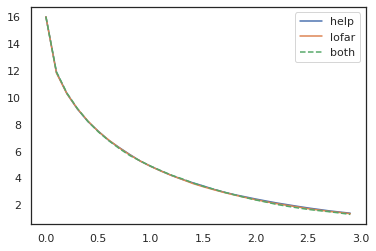

In [45]:
pixels_lofar = find_pixels(ras,decs,18/3600,priors_lofar,posterior_lofar)
pixels_help = find_pixels(ras,decs,18/3600,priors_help,posterior_help)
#pixels_help = [np.array([ 99, 118, 119, 120, 138, 139, 140, 157, 158, 159, 177, 178, 179, 196, 197])]
pixels_both = find_pixels(ras,decs,18/3600,priors_both,posterior_both)
        
sigmas = np.arange(0,3,0.1)
y_lofar = []
y_help = []
y_both = []
ks_test = []
sign = []
for sigma in sigmas:
    y_lofar.append(pval_summary(pixels_lofar,sigma,rep_map_lofar[0],priors_lofar[0]))
    y_help.append(pval_summary(pixels_help,sigma,rep_map_help[0],priors_help[0]))
    y_both.append(pval_summary(pixels_both,sigma,rep_map_both[0],priors_both[0]))

y_lofar = np.array(y_lofar)
y_help = np.array(y_help)
y_both = np.array(y_both)
ks_test.append(ks_2samp(np.array(y_both),np.array(y_help)))
            
diff = np.array(y_both) - np.array(y_help)
abs_diff = abs(diff)
sign.append(diff[np.argmax(abs_diff)])

plt.plot(sigmas,y_help,label='help')
plt.plot(sigmas,y_lofar,label='lofar')
plt.plot(sigmas,y_both,label='both',linestyle='dashed')
plt.legend()
plt.show()

In [ ]:
ks_test

In [ ]:
sign

In [ ]:
f = open('data/fir/SPIRE/KS_lofar_rerun.pkl','rb')
KS_results = pickle.load(f)

KS_table = Table()
col_id = Column(data = np.array(KS_results[2])[:,0], name='Source_Name')
col_KS_stat = Column(data=np.array([KS_results[0][n].statistic for n in range(len(KS_results[0]))]), name='KS_statistic')
col_KS_pval = Column(data=np.array([KS_results[0][n].pvalue for n in range(len(KS_results[0]))]), name='KS_pval')
col_KS_sign = Column(data=np.array([KS_results[1][n] for n in range(len(KS_results[0]))]), name='KS_sign')
col_lofar_tile = Column(data = np.array(KS_results[2])[:,1], name='lofar_file')
col_help_tile = Column(data = np.array(KS_results[2])[:,2], name='help_file')
KS_table.add_columns([col_id,col_KS_stat,col_KS_pval,col_KS_sign,col_lofar_tile,col_help_tile])

In [ ]:
mask = KS_table['Source_Name']==ids
KS_table[mask]

In [ ]:
ks_test

In [ ]:
sign

In [ ]:
lofar_tmp = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
mask = (~np.isnan(lofar_tmp['F_SPIRE_250'])) | (~np.isnan(lofar_tmp['F_SPIRE_350'])) | (~np.isnan(lofar_tmp['F_SPIRE_500']))
lofar_tmp = lofar_tmp[~mask]
batch_size = 20

num = int(np.argmax(lofar['Source_Name']==ids)/20)

file = 'data/fir/SPIRE/xidplus_run_{}/lofar_xidplus_fir_{}_rerun.pkl'.format(num,num)
priors_old_lofar,posterior_old_lofar = xidplus.load(file)
rep_map_old_lofar = postmaps.replicated_maps(priors_old_lofar,posterior_old_lofar)
    
filename = file

'''taskid = num
ind_low = taskid*batch_size
if taskid*batch_size+batch_size>len(lofar):
    ind_up = len(lofar)
else:
    ind_up = taskid*batch_size+batch_size
ras = lofar['optRA'][ind_low:ind_up]
mask = np.isnan(ras)
ras[mask] = lofar['RA'][ind_low:ind_up][mask]

decs = lofar['optDec'][ind_low:ind_up]
mask = np.isnan(decs)
decs[mask] = lofar['DEC'][ind_low:ind_up][mask]

ids_centre = lofar['Source_Name'][ind_low:ind_up]'''
sources_done = []
filenames = glob.glob('/lustre/scratch/astro/pdh21/ELAIS_N1/SPIRE/output/Tile_*_9.pkl')
tiles = [int(name.split('/')[-1].split('_')[1]) for name in filenames]
healpixids,filepaths = get_xidplus_posterior(ids,9,tiles,ras=ras,decs=decs,filepath='/lustre/scratch/astro/pdh21/ELAIS_N1/SPIRE/output/')
ks_test_old = []
sign_old = []

for n,help_run in enumerate(np.unique(filepaths)):
    #print(help_run)
    ra_target = ras
    dec_target = decs
    ids_target = ids
        
    priors_old_help,posterior_old_help = xidplus.load(help_run)
    rep_map_old_help = postmaps.replicated_maps(priors_old_help,posterior_old_help)
    
    pixels_lofar = find_pixels(ra_target,dec_target,18/3600,priors_old_lofar,posterior_old_lofar)
    pixels_help = find_pixels(ra_target,dec_target,18/3600,priors_old_help,posterior_old_help)
    
    #print(pixels_lofar)

    for n,source in enumerate(pixels_lofar):
        sigmas = np.arange(0,3,0.1)
        y_lofar = []
        y_help = []
        for sigma in sigmas:
            y_lofar.append(pval_summary(pixels_lofar[n],sigma,rep_map_old_lofar[0],priors_old_lofar[0]))
            y_help.append(pval_summary(pixels_help[n],sigma,rep_map_old_help[0],priors_old_help[0]))
    
        #print(ks_2samp(np.array(y_lofar),np.array(y_help)))
        ks_test.append(ks_2samp(np.array(y_lofar),np.array(y_help)))
            
        diff = np.array(y_lofar) - np.array(y_help)
        abs_diff = abs(diff)
        sign.append(diff[np.argmax(abs_diff)])

        sources_done.append([ids_target[n],file,help_run])
        
        plt.plot(sigmas,y_lofar,label='LOFAR')
        plt.plot(sigmas,y_help,label='HELP')
        plt.legend()
        plt.show()

In [ ]:
print(sign_old)
ks_test_old

In [ ]:
sources_done

In [ ]:
print(ras.data)
print(decs.data)

In [ ]:
xidplus.plot_map(priors_old_help)

In [ ]:
mask = [SPIRE_cat['HELP_ID'][i] in ids for i in range(len(SPIRE_cat))]
#mask2 = ['ILTJ' in ]
SPIRE_cat[mask]

In [ ]:
mask = 'ILTJ' in SPIRE_cat['HELP_ID']
mask_lofar = lofar['ra']==ra
mask_pcat = prior_cat['help_id']=='lofar'
SPIRE_cat = SPIRE_cat[mask]
SPIRE_cat.add_columns([prior_cat['f_mips_24'][mask_pcat],prior_cat['flag_optnir_det'][mask_pcat]])
lofar_fir = hstack([lofar[mask_lofar],SPIRE_cat])
XID_rerun_col = Column(data=XID_rerun,name='XID_rerun',dtype=bool)
source_type_col = Column(data=source_type,name='source_type',dtype=str)
lofar_fir.add_columns([XID_rerun_col,source_type_col])
    
#os.mkdir('testfolder')
#Table.write(lofar_fir,'testfolder/lofar_xidplus_fir.fits')

In [ ]:
lofar_fir

In [ ]:
os.path.exists('data/fir_v2/xidplus_run_3')

In [ ]:
len(lofar)